In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
import numpy as np
import torch
from matplotlib import pyplot as plt

from counterfactuals.datasets import MoonsDataset
from counterfactuals.losses import MulticlassDiscLoss
from counterfactuals.cf_methods.group_ppcef.rppcef import RPPCEF
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import MultilayerPerceptron
from counterfactuals.metrics import CFMetrics

from counterfactuals.plot_utils import (
    plot_generative_model_distribution,
    plot_classifier_decision_region,
)

In [12]:
dataset = MoonsDataset("../data/moons.csv")

In [9]:
disc_model = MultilayerPerceptron(dataset.X_test.shape[1], [512, 512], 2)
disc_model.fit(
    dataset.train_dataloader(batch_size=128, shuffle=True),
    dataset.test_dataloader(batch_size=128, shuffle=False),
    epochs=5000,
    patience=100,
    lr=1e-3,
    checkpoint_path="moons_disc_model.pt",
)
# disc_model.load("heloc_disc_model.pt")

Epoch 311, Train: 0.0009, test: 0.0102, patience: 100:   6%|▌         | 312/5000 [00:06<01:35, 49.17it/s]
/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loade

In [13]:
y_pred = disc_model.predict(dataset.X_test).detach().numpy().flatten()
print("Test accuracy:", (y_pred == np.argmax(dataset.y_test, axis=1)).mean())

Test accuracy: 1.0


In [16]:
dataset.y_train = dataset.y_transformer.transform(
    disc_model.predict(dataset.X_train).detach().numpy().reshape(-1, 1)
)
dataset.y_test = dataset.y_transformer.transform(
    disc_model.predict(dataset.X_test).detach().numpy().reshape(-1, 1)
)

In [ ]:
gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1],
    hidden_features=16,
    num_blocks_per_layer=2,
    num_layers=5,
    context_features=2,
    batch_norm_within_layers=True,
    batch_norm_between_layers=True,
    use_random_permutations=True,
)
train_dataloader = dataset.train_dataloader(
    batch_size=256, shuffle=True, noise_lvl=0.03
)
test_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)

gen_model.fit(
    train_dataloader,
    train_dataloader,
    learning_rate=1e-3,
    patience=100,
    num_epochs=500,
    checkpoint_path="moons_flow.pth",
)
# gen_model.load("heloc_flow.pth")

Epoch 485, Train: -0.9376, test: -0.9243, patience: 100:  97%|█████████▋| 485/500 [00:21<00:00, 22.84it/s]
/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/generative_models/maf/maf.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please op

In [25]:
source_class = 0
target_class = 1
X_test_origin = dataset.X_test[np.argmax(dataset.y_test, axis=1) == source_class]
y_test_origin = dataset.y_test[np.argmax(dataset.y_test, axis=1) == source_class]

In [94]:
# dataset.actionable_features = [0, 1, 2, 3, 4]
# dataset.not_actionable_features = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
cf_method = RPPCEF(
    X=X_test_origin,
    cf_method_type="GCE",
    K=2,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(eps=0.01),
    not_actionable_features=None,
    neptune_run=None,
)

train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.1,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)

In [120]:
# dataset.actionable_features = [0, 1, 2, 3, 4]
# dataset.not_actionable_features = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
cf_method = RPPCEF(
    X=X_test_origin,
    cf_method_type="GCE",
    K=2,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(eps=0.01),
    not_actionable_features=None,
    neptune_run=None,
)

train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.1,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)

In [124]:
delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    target_class=target_class,
    epochs=20000,
    lr=0.001,
    patience=500,
    alpha_dist=1e1,
    alpha_plaus=10**3,
    alpha_class=10**5,
    alpha_s=10**3,
    alpha_k=10**1,
    log_prob_threshold=log_prob_threshold,
)

M, S, D = delta.get_matrices()
print(S.sum(axis=0))
Xs_cfs = Xs + delta().detach().numpy()

values, indexes = S.max(dim=1)

total = len(values)
i_correct = indexes[values == 1]
print(f"Correct: {len(i_correct)}/{total}")
print(len(set(i_correct.tolist())))

metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)
metrics.calc_all_metrics()

  0%|          | 0/20000 [00:00<?, ?it/s]

loss: 203.2975, dist: 4.3518, max_inner: 152.8106, loss_disc: 0.0000, delta_loss: 6.9688:  14%|█▎        | 2718/20000 [00:16<01:45, 163.47it/s] 


tensor([54., 49.], grad_fn=<SumBackward1>)
Correct: 103/103
2


{'coverage': 1.0,
 'validity': 1.0,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 0.32808133032656034,
 'proximity_continuous_manhattan': 0.43518281545607573,
 'proximity_continuous_euclidean': 0.32808133032656034,
 'proximity_continuous_mad': 2.266466904612421,
 'proximity_l2_jaccard': 0.32808133032656034,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.8932038834951457,
 'log_density_cf': 0.6387579,
 'log_density_test': 1.3997155,
 'lof_scores_cf': 1.2654016,
 'lof_scores_test': 1.0530212,
 'isolation_forest_scores_cf': -0.016899442421379602,
 'isolation_forest_scores_test': 0.003182315741079119}

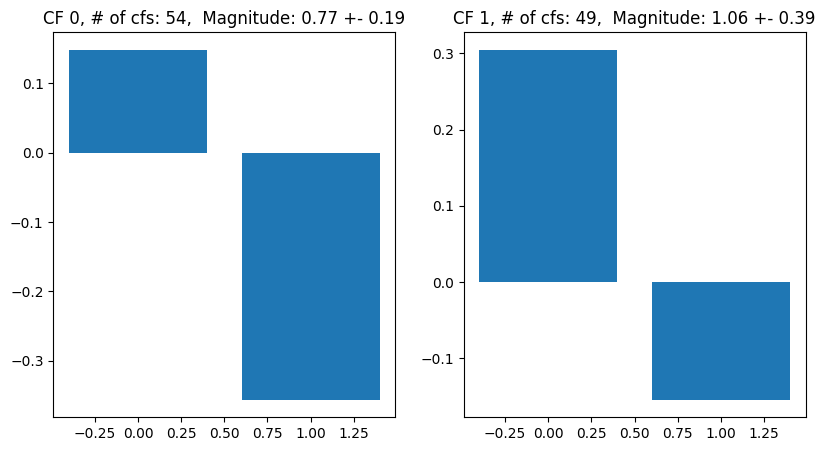

In [125]:
plt.figure(figsize=(15, 5))

groups = S.argmax(dim=1)

for i in range(D.shape[0]):
    plt.subplot(1, 3, i + 1)
    plt.bar(range(2), D[i].detach().numpy())
    mean_magn = M.squeeze()[groups == i].mean(axis=0)
    std_magn = M.squeeze()[groups == i].std(axis=0)
    n_vectors = (S.argmax(axis=1) == i).sum()
    plt.title(
        f"CF {i}, # of cfs: {n_vectors},  Magnitude: {mean_magn:.2f} +- {std_magn:.2f}"
    )

In [130]:
import matplotlib

/var/folders/br/pgzj4v8d4h5dpw0k8803m4hc0000gn/T/ipykernel_29032/3545500869.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(xs_cfs_group[:, 0], xs_cfs_group[:, 1], c="orange", cmap=matplotlib.colormaps["tab10"], s=40, alpha=0.6)
/var/folders/br/pgzj4v8d4h5dpw0k8803m4hc0000gn/T/ipykernel_29032/3545500869.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(xs_group[:, 0], xs_group[:, 1], c=group_colors[group_i], cmap=matplotlib.colormaps["tab10"], s=40, alpha=0.6)


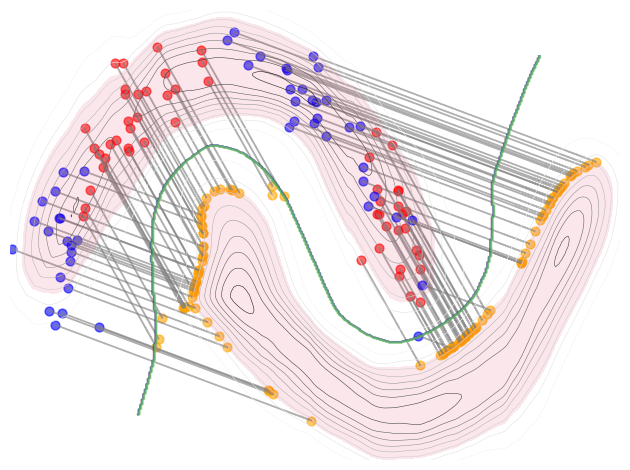

In [150]:
# fig, ax = plt.subplots(figsize=(10, 10))
fig, ax = plt.subplots(1, 1)


# Add arrows between each Xs and Xs_cfs
group_colors = [
    "red",
    "blue",
    "green",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
group_cf_colors = [
    "orange",
    "purple",
    "green",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
for group_i in range(S.shape[1]):
    xs_group = Xs[S.argmax(dim=1) == group_i]
    xs_cfs_group = Xs_cfs[S.argmax(dim=1) == group_i]
    ax.scatter(
        xs_cfs_group[:, 0],
        xs_cfs_group[:, 1],
        c="orange",
        cmap=matplotlib.colormaps["tab10"],
        s=40,
        alpha=0.6,
    )
    ax.scatter(
        xs_group[:, 0],
        xs_group[:, 1],
        c=group_colors[group_i],
        cmap=matplotlib.colormaps["tab10"],
        s=40,
        alpha=0.6,
    )
    for i in range(len(xs_group)):
        ax.arrow(
            xs_group[i, 0],
            xs_group[i, 1],
            xs_cfs_group[i, 0] - xs_group[i, 0],
            xs_cfs_group[i, 1] - xs_group[i, 1],
            head_width=0.00,
            head_length=-0.05,
            fc="grey",
            ec="grey",
            # fc=group_colors[group_i],
            # ec=group_colors[group_i],
            alpha=0.5,
        )
# for i in range(len(Xs)):
#     ax.arrow(
#         Xs[i, 0],
#         Xs[i, 1],
#         Xs_cfs[i, 0] - Xs[i, 0],
#         Xs_cfs[i, 1] - Xs[i, 1],
#         head_width=0.02,
#         head_length=0.00,
#         fc="gray",
#         ec="gray",
#         alpha=0.5,
# )

plot_generative_model_distribution(ax, gen_model, log_prob_threshold, 2)
plot_classifier_decision_region(ax, disc_model)
# plot_observations(ax, Xs, ys_orig, group_colors)
# plot_counterfactuals(ax, Xs_cfs)
# plot_arrows(ax, Xs, Xs_cfs)
# remove boundaries
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# remove frame
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.tight_layout()
plt.savefig("teaser_groupwise.pdf", dpi=300)
plt.show()

# Global

In [188]:
cf_method = RPPCEF(
    X=X_test_origin,
    cf_method_type="GCE",
    K=1,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(eps=0.01),
    not_actionable_features=None,
    neptune_run=None,
)

train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.1,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)

In [216]:
delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    target_class=target_class,
    epochs=100,
    lr=0.001,
    patience=500,
    alpha_dist=1e-1,
    alpha_plaus=10**3,
    alpha_class=10**8,
    alpha_s=0,
    alpha_k=0,
    log_prob_threshold=log_prob_threshold,
)

M, S, D = delta.get_matrices()
print(S.sum(axis=0))
Xs_cfs = Xs + delta().detach().numpy()

values, indexes = S.max(dim=1)

total = len(values)
i_correct = indexes[values == 1]
print(f"Correct: {len(i_correct)}/{total}")
print(len(set(i_correct.tolist())))

metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)
metrics.calc_all_metrics()

loss: 2437702.2500, dist: 0.0482, max_inner: 9541.2295, loss_disc: 2428161.0000, delta_loss: 0.0057:   0%|          | 0/100 [00:00<?, ?it/s]

loss: 14545.3604, dist: 0.0503, max_inner: 14545.3516, loss_disc: 0.0000, delta_loss: 0.0044: 100%|██████████| 100/100 [00:00<00:00, 179.34it/s]       


tensor([103.], grad_fn=<SumBackward1>)
Correct: 103/103
1


{'coverage': 1.0,
 'validity': 1.0,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 0.385226489554849,
 'proximity_continuous_manhattan': 0.503431713102313,
 'proximity_continuous_euclidean': 0.385226489554849,
 'proximity_continuous_mad': 2.4654678601084403,
 'proximity_l2_jaccard': 0.385226489554849,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.6893203883495146,
 'log_density_cf': -13.598974,
 'log_density_test': 1.3997155,
 'lof_scores_cf': 1.7026446,
 'lof_scores_test': 1.0530212,
 'isolation_forest_scores_cf': -0.0182781524349574,
 'isolation_forest_scores_test': 0.003182315741079119}

/var/folders/br/pgzj4v8d4h5dpw0k8803m4hc0000gn/T/ipykernel_29032/2256219186.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(xs_cfs_group[:, 0], xs_cfs_group[:, 1], c="orange", cmap=matplotlib.colormaps["tab10"], s=40, alpha=0.6)
/var/folders/br/pgzj4v8d4h5dpw0k8803m4hc0000gn/T/ipykernel_29032/2256219186.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(xs_group[:, 0], xs_group[:, 1], c=group_colors[group_i], cmap=matplotlib.colormaps["tab10"], s=40, alpha=0.6)


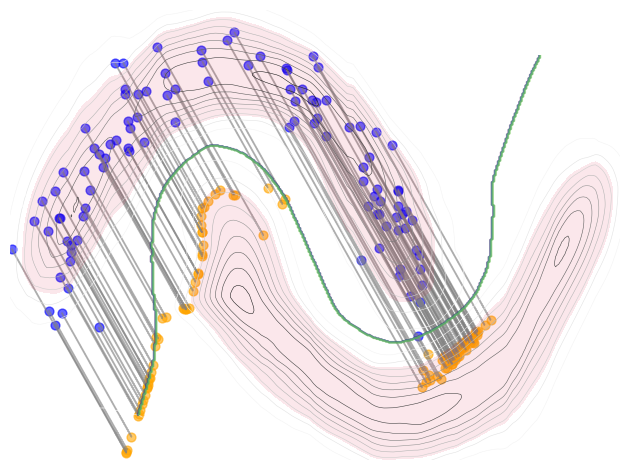

In [218]:
# fig, ax = plt.subplots(figsize=(10, 10))
fig, ax = plt.subplots(1, 1)
# Add arrows between each Xs and Xs_cfs
group_colors = [
    "blue",
    "red",
    "green",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
group_cf_colors = [
    "orange",
    "purple",
    "green",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
for group_i in range(S.shape[1]):
    xs_group = Xs[S.argmax(dim=1) == group_i]
    xs_cfs_group = Xs_cfs[S.argmax(dim=1) == group_i]
    ax.scatter(
        xs_cfs_group[:, 0],
        xs_cfs_group[:, 1],
        c="orange",
        cmap=matplotlib.colormaps["tab10"],
        s=40,
        alpha=0.6,
    )
    ax.scatter(
        xs_group[:, 0],
        xs_group[:, 1],
        c=group_colors[group_i],
        cmap=matplotlib.colormaps["tab10"],
        s=40,
        alpha=0.6,
    )
    for i in range(len(xs_group)):
        ax.arrow(
            xs_group[i, 0],
            xs_group[i, 1],
            xs_cfs_group[i, 0] - xs_group[i, 0],
            xs_cfs_group[i, 1] - xs_group[i, 1],
            head_width=0.00,
            head_length=-0.05,
            fc="grey",
            ec="grey",
            alpha=0.5,
        )

plot_generative_model_distribution(ax, gen_model, log_prob_threshold, 2)
plot_classifier_decision_region(ax, disc_model)
# remove boundaries
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# remove frame
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.tight_layout()
plt.savefig("teaser_global.pdf", dpi=300)
plt.show()

# LOCAL

In [224]:
cf_method = RPPCEF(
    X=X_test_origin,
    cf_method_type="GCE",
    K=None,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(eps=0.01),
    not_actionable_features=None,
    neptune_run=None,
)

train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.1,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)

In [225]:
delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    target_class=target_class,
    epochs=20000,
    lr=0.01,
    patience=500,
    alpha_dist=1e1,
    alpha_plaus=10**3,
    alpha_class=10**8,
    alpha_s=0,
    alpha_d=0,
    alpha_k=0,
    log_prob_threshold=log_prob_threshold,
)

M, S, D = delta.get_matrices()
print(S.sum(axis=0))
Xs_cfs = Xs + delta().detach().numpy()

values, indexes = S.max(dim=1)

total = len(values)
i_correct = indexes[values == 1]
print(f"Correct: {len(i_correct)}/{total}")
print(len(set(i_correct.tolist())))

metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)
metrics.calc_all_metrics()

  0%|          | 0/20000 [00:00<?, ?it/s]

loss: 30.5942, dist: 3.0594, max_inner: 0.0000, loss_disc: 0.0000, delta_loss: 0.0000: 100%|██████████| 20000/20000 [02:53<00:00, 114.98it/s]                


tensor([4.0561e-01, 8.7732e-01, 1.1469e+00, 0.0000e+00, 2.2306e-01, 1.0030e+00,
        0.0000e+00, 5.9442e+00, 0.0000e+00, 0.0000e+00, 5.2465e-01, 0.0000e+00,
        1.8291e+00, 0.0000e+00, 0.0000e+00, 3.0192e+00, 4.0371e-01, 0.0000e+00,
        5.8759e+00, 0.0000e+00, 5.0789e-04, 1.9363e-01, 0.0000e+00, 5.0587e-01,
        0.0000e+00, 0.0000e+00, 2.1822e-01, 1.1501e-01, 2.7269e-01, 0.0000e+00,
        0.0000e+00, 7.9136e-01, 0.0000e+00, 5.2171e-01, 0.0000e+00, 4.4927e-01,
        3.3735e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2364e+00, 2.3925e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0378e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8424e+00,
        0.0000e+00, 2.1988e+00, 0.0000e+00, 0.0000e+00, 7.1154e-01, 0.0000e+00,
        4.9516e-02, 0.0000e+00, 0.0000e+00, 1.8667e-01, 2.2299e-01, 0.0000e+00,
        0.0000e+00, 5.0721e+00, 0.0000e+00, 8.6737e-01, 2.1148e+00, 2.9356e-01,
        2.0948e+01, 1.0858e+00, 0.0000e+

{'coverage': 1.0,
 'validity': 1.0,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 0.25521284696536006,
 'proximity_continuous_manhattan': 0.3058186050310044,
 'proximity_continuous_euclidean': 0.25521284696536006,
 'proximity_continuous_mad': 1.6340738992089208,
 'proximity_l2_jaccard': 0.25521284696536006,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.9805825242718447,
 'log_density_cf': 0.9053188,
 'log_density_test': 1.3997155,
 'lof_scores_cf': 1.1225772,
 'lof_scores_test': 1.0530212,
 'isolation_forest_scores_cf': 0.0010005641119351925,
 'isolation_forest_scores_test': 0.003182315741079119}

/var/folders/br/pgzj4v8d4h5dpw0k8803m4hc0000gn/T/ipykernel_29032/657082727.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(xs_cfs_group[:, 0], xs_cfs_group[:, 1], c="orange", cmap=matplotlib.colormaps["tab10"], s=40, alpha=0.6)
/var/folders/br/pgzj4v8d4h5dpw0k8803m4hc0000gn/T/ipykernel_29032/657082727.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(xs_group[:, 0], xs_group[:, 1], c=group_colors[0], cmap=matplotlib.colormaps["tab10"], s=40, alpha=0.6)


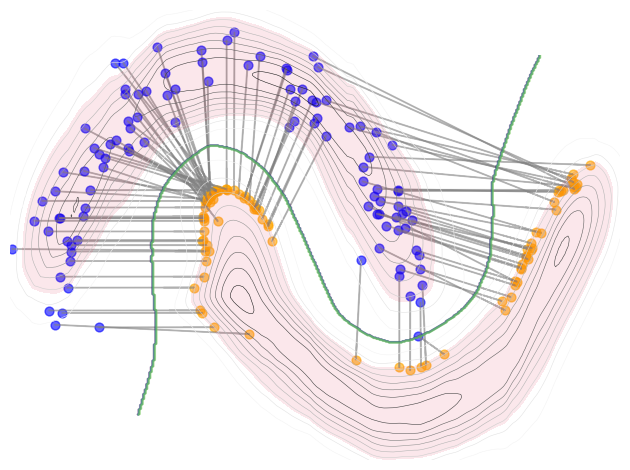

In [226]:
# fig, ax = plt.subplots(figsize=(10, 10))
fig, ax = plt.subplots(1, 1)
# Add arrows between each Xs and Xs_cfs
group_colors = [
    "blue",
    "red",
    "green",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
group_cf_colors = [
    "orange",
    "purple",
    "green",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
for group_i in range(S.shape[1]):
    xs_group = Xs[S.argmax(dim=1) == group_i]
    xs_cfs_group = Xs_cfs[S.argmax(dim=1) == group_i]
    ax.scatter(
        xs_cfs_group[:, 0],
        xs_cfs_group[:, 1],
        c="orange",
        cmap=matplotlib.colormaps["tab10"],
        s=40,
        alpha=0.6,
    )
    ax.scatter(
        xs_group[:, 0],
        xs_group[:, 1],
        c=group_colors[0],
        cmap=matplotlib.colormaps["tab10"],
        s=40,
        alpha=0.6,
    )
    for i in range(len(xs_group)):
        ax.arrow(
            xs_group[i, 0],
            xs_group[i, 1],
            xs_cfs_group[i, 0] - xs_group[i, 0],
            xs_cfs_group[i, 1] - xs_group[i, 1],
            head_width=0.00,
            head_length=-0.05,
            fc="grey",
            ec="grey",
            alpha=0.5,
        )

plot_generative_model_distribution(ax, gen_model, log_prob_threshold, 2)
plot_classifier_decision_region(ax, disc_model)
# remove boundaries
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# remove frame
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.tight_layout()
plt.savefig("teaser_local.pdf", dpi=300)
plt.show()